In [183]:
import pandas as pd
import numpy as np
from numpy import log
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from workalendar.america import Canada
import itertools
import sys
# Deep learning: 
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import model_from_json
import itertools
from sklearn.preprocessing import MinMaxScaler
np.set_printoptions(threshold=sys.maxsize)

DAYS_IN_YEAR = 365
HOURS_IN_DAY = 24
DAYS_OF_WEEK = ['week_1','week_2','week_3','week_4','week_5','week_6','week_7']
MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
MINUTES_IN_DAY = MINUTES_IN_HOUR * HOURS_IN_DAY

In [190]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data_path: str,
        Y_var: str,
        model_save: str,
        model_load: str,
        granularity: str,
        export_file_path: str,
        lag: int,
        lag2: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0,
        n_test = 96,
    ):
        
        self.data_path = data_path
        self.model_save = model_save
        self.model_load = model_load
        self.granularity = granularity
        self.export_file_path = export_file_path
        self.Y_var = Y_var 
        self.lag = lag 
        self.lag2 = lag2
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split
        self.n_test = n_test
        self.data = pd.read_csv(data_path, index_col=0)
        self.data = self.preprocess(self.data)
    
    @classmethod
    def get_fractional_hour_from_series(self, series: pd.Series) -> pd.Series:
        """
        Return fractional hour in range 0-24, e.g. 12h30m --> 12.5.
        Accurate to 1 minute.
        """
        hour = series.hour
        minute = series.minute
        return hour + minute / MINUTES_IN_HOUR

    @classmethod
    def get_fractional_day_from_series(self, series: pd.Series) -> pd.Series:
        """
        Return fractional day in range 0-1, e.g. 12h30m --> 0.521.
        Accurate to 1 minute
        """
        fractional_hours = self.get_fractional_hour_from_series(series)
        return fractional_hours / HOURS_IN_DAY

    @classmethod
    def get_fractional_year_from_series(self, series: pd.Series) -> pd.Series:
        """
        Return fractional year in range 0-1.
        Accurate to 1 day
        """
        return (series.dayofyear - 1) / DAYS_IN_YEAR

    def preprocess(self, dataframe):
        dataframe.index = pd.to_datetime(dataframe.index)
        # Removing duplicates
        dataframe = dataframe[~dataframe.index.duplicated()]
        
        #Filling NaN values
        dataframe = dataframe.interpolate()
        
        # Setting the calendar holidats
        cal = Canada()
        years = list(range(2014, 2025))
        holidays = []
        for year in years:
            holidays.extend(cal.holidays(year))
            
        dataframe = dataframe.sort_index()
        
        #print('preprocess:')
        #print(dataframe.columns)
        # Rename the target column to 'Valeur' for convenience
        dataframe.rename(columns={dataframe.columns[0]: self.Y_var}, inplace=True)
        
        # Logarithmic transform add 1 for non-negative data (zeros in the series)
        #dataframe[self.Y_var] = log(dataframe[self.Y_var] + 1)
        
        #working day {0,1}
        dataframe['working day'] = dataframe.index.map(cal.is_working_day).astype(np.float32)
        
        #fractional hour [0,1]
        dataframe['fractional hour'] = self.get_fractional_day_from_series(dataframe.index)
        
        # day of week one-hot encoded
        dataframe['day of week'] = dataframe.index.dayofweek + 1
        dataframe['day of week'] = pd.Categorical(dataframe['day of week'], categories=[1,2,3,4,5,6,7], ordered=True)
        dataframe = pd.get_dummies(dataframe,prefix=['week'], columns = ['day of week'], drop_first=False)
        #dataframe = pd.concat([dataframe, pd.DataFrame(columns=DAYS_OF_WEEK)]).fillna(0)
        
        
        # fractional day of year
        dataframe['day of year'] = self.get_fractional_year_from_series(dataframe.index)
        
        # we encode cynical data into two dimensions using a sine and cosine transformations
        def encode(data, col, max_val):
            data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
            data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
            return data
        dataframe = encode(dataframe, 'fractional hour', HOURS_IN_DAY)
        dataframe = encode(dataframe, 'day of year', DAYS_IN_YEAR)
        # dropping original columns
        dataframe = dataframe.drop(['fractional hour','day of year'], axis=1)
        return dataframe
    
    @staticmethod    
    def plot_train_history(model):
        '''
        Convergence plots to have an idea on how the training performs
        '''
        loss = model.history.history['loss']
        val_loss = model.history.history['val_loss']
        plt.figure()
        plt.plot(range(len(loss)), loss, 'b', label='Training loss')
        plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
        #plt.yscale("log")
        plt.xlabel('Epochs')
        plt.ylabel('Losses')
        plt.title('Training and validation losses')
        plt.legend()
        plt.show() 
    
    @staticmethod
    def validation(forecasted, real, parameter):
        ''' 
        compute some important parameters to compare forecasting results
        '''
        value = 0
        value_1 = 0
        value_2 = 0

        if parameter == 'SMAPE':
            for i in range(len(forecasted)):
                if real[i] + forecasted[i] == 0:
                    value += 0
                else: 
                    value += ((abs(real[i] - forecasted[i])) / (real[i] + forecasted[i])) * 100
            final_value = value / len(forecasted)  

        elif parameter == 'MAPE':
            for i in range(len(forecasted)):
                if real[i] == 0:
                    value += 0
                else: 
                    value += (abs(real[i] - forecasted[i]))/real[i]
            final_value = value / len(forecasted) * 100

        elif parameter == 'RMSE':
            for i in range(len(forecasted)):
                value += (real[i] - forecasted[i]) ** 2
            final_value = (value / len(forecasted)) ** (1 / 2) 

        elif parameter == 'R':
            for i in range(len(forecasted)):
                value += (real[i] - np.mean(real)) * (forecasted[i] - np.mean(forecasted))
                value_1 += (real[i] - np.mean(real)) ** 2
                value_2 += (forecasted[i] - np.mean(forecasted)) ** 2

            if value_1 == 0 or value_2 == 0:
                final_value = 100
            else:
                final_value = (value / ((value_1 ** (1 / 2)) * (value_2 ** (1 / 2))))*100

        return final_value
    
    def normalize(self, tensor):
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        tensor = self.scaler.fit_transform(tensor)
        return tensor
    
    def denormalize(self, tensor):
        tensor = self.scaler.inverse_transform(tensor)
        return tensor      

    # convert series to supervised learning
    def series_to_supervised(self, data, dropnan=True):
        n_vars = 1
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in [self.lag, self.lag2]:
            cols.append(df[self.Y_var].shift(i))
            names += [(self.Y_var+'(t-%d)' % (i))]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg   
    
    def create_data_for_NN(self):
        reframed = self.data.merge(self.series_to_supervised(self.data), how='right', left_index=True, right_index=True)
        #print(reframed.head())
        # Normalize with a MinMax Scaler
        reframed = self.normalize(reframed)
        #reframed = np.array(reframed)
        #print(reframed[:10])
        
        #Assign validation data to fix referencing
        X_val, Y_val = [], []
        
        test = reframed[-self.n_test:]
        index = len(reframed) - self.n_test
        train = reframed[:round(index * (1-self.train_test_split))]
        if self.train_test_split > 0:
            val = reframed[round(index * (1-self.train_test_split)):index]
            
        X_train, Y_train = train[:, 1:], train[:, 0]
        if self.train_test_split > 0:
            X_val, Y_val = val[:, 1:], val[:, 0]
        X_test, Y_test = test[:, 1:], test[:, 0]
        
        #print(X_train[:10])
        
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        if self.train_test_split > 0:
            X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
        #print(X_test.shape)
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        #print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
        
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    def save_model(self, model):
        model_json = model.to_json()
        with open(self.model_save+'.json', "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights(self.model_save+'.h5')
        print("Model saved to disk")
          
    def load_model(self):
        # load json and create model
        json_file = open(self.model_load+".json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        # load weights into new model
        self.model.load_weights(self.model_load+".h5")
        print("Loaded model from disk")
    
    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_val, X_test, Y_train, Y_val, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(LSTM(self.LSTM_layer_depth, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mae')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=10)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            #'callbacks': [earlyStop, csv_logger]
            'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_val, Y_val)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model
        # Plotting train history
        if self.train_test_split > 0:
            self.plot_train_history(model)
        # Saving the model in json and h5
        self.save_model(self.model)
        
        return model  

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        # Getting the last n time series 
        _, _, X_test, _, _, Y_test = self.create_data_for_NN()
        
        # Making the prediction list 
        yhat = self.model.predict(X_test)

        # Reshape for merging with predictions
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

        # invert scaling for forecast
        inv_yhat = np.concatenate((yhat, X_test), axis=1)

        # denormalize
        inv_yhat = self.scaler.inverse_transform(inv_yhat)

        # invert scaling for actual
        Y_test = Y_test.reshape((len(Y_test), 1))

        inv_y = np.concatenate((Y_test, X_test), axis=1)

        # denormalize
        inv_y = self.scaler.inverse_transform(inv_y)
        
        act = [i[0] for i in inv_y] # last element is the predicted average energy
        pred = [i[0] for i in inv_yhat] # last element is the actual average energy

        # Reverse the log transformation and substract by one if the data contains zero
        #act = np.exp(act) - 1
        #pred = np.exp(pred) - 1
        
        return act, pred
    
    def results(self):
        expected, predictions = self.predict()# Constructing the forecast dataframe
        
        print('RMSE: %f [kWh]' % self.validation(predictions,expected, 'RMSE'))
        print('MAPE: %f %%' % self.validation(predictions,expected, 'MAPE'))
        print('\n')
    
    def plot_test(self):
        expected, predictions = self.predict()# Constructing the forecast dataframe      
        fc = self.data.tail(len(expected)).copy()
        print('RMSE: %f [kWh]' % self.validation(predictions,expected, 'RMSE'))
        print('MAPE: %f %%' % self.validation(predictions,expected, 'MAPE'))
        # Ploting the forecasts
        plt.figure(figsize=(12, 8))
        #for dtype in ['Valeur', 'forecast']:  
        plt.plot(fc.index, expected, label='Valeur',alpha=0.7)
        plt.plot(fc.index, predictions, label='forecast',alpha=0.7)
        plt.legend()
        plt.grid()

        plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
        plt.yticks(fontsize=12, alpha=.7)
        plt.title("Consumption for test data", fontsize=20)

        plt.show()
    
    def predict_n_ahead(self, data_input, n_ahead: int):
        # Set up a dataset with next n timestamps
        dates = pd.date_range(data_input.index[-1], periods = n_ahead+1, freq=self.granularity)[1:]
        test = data_input.append(pd.DataFrame(index=dates))
        test.index=data_input.index.union(dates)

        # Add all temporal features
        test = self.preprocess(test)
        
        # Merge temporal features with lags
        test = test.merge(self.series_to_supervised(test), how='right', left_index=True, right_index=True)
        
        # Normalize with a MinMax scaler
        test = self.normalize(test)
        
        # Take out the forecasted metric
        test = test[:, 1:]
        
        # Reshape the tensor to LSTM input
        test = test.reshape((test.shape[0], 1, test.shape[1]))
        
        # Forecast for n_ahead steps ahead
        yhat = []
        yhat = self.model.predict(test)
        
        # Reshape for merging with predictions
        test = test.reshape(test.shape[0], test.shape[2])
        
        # invert scaling for forecast
        inv_yhat = np.concatenate((yhat, test), axis=1)
        
        # denormalize
        inv_yhat = self.scaler.inverse_transform(inv_yhat)
        
        yhat = [i[0] for i in inv_yhat] # last element is the predicted average energy
        return yhat[-n_ahead:]
    
    def evaluate_n_ahead(self, data_temp, n_ahead: int):
        # take the user input dataset as the one we predict ahead for
        yhat = []
        predictions = []
        # Rename the first column so it is consistent along the code
        data_temp.rename(columns={data_temp.columns[0]: self.Y_var}, inplace=True)
        data_temp.index = pd.to_datetime(data_temp.index)
        # Load model if no preloaded
        if hasattr('self', 'model') == False:
            self.load_model()
        # Slide through the dataset by window of 96 steps and refeed the predictions into inputs
        for i in tf.range(n_ahead//self.lag+1):
            y_hat = self.predict_n_ahead(data_temp, self.lag)
            data_temp = data_temp.append(pd.DataFrame(y_hat, columns=['Valeur'], index=pd.date_range(data_temp.index[-1], periods = self.lag+1, freq=self.granularity)[1:]))
            data_temp.drop(data_temp.head(self.lag).index, inplace=True)
            predictions.extend(y_hat)
        # Create a dataset for predictions
        predictions = predictions[:n_ahead]
        dates = pd.date_range(data_temp.index[-1], periods = n_ahead+1, freq=self.granularity)[1:]
        test = pd.DataFrame(predictions)
        test.index = dates
        test.index = pd.to_datetime(test.index)
        # Save to a csv
        test.to_csv(self.export_file_path, index=True)
        #expected = test_range.head(n_ahead).loc[:,"Valeur"]
        
        #predictions = test.iloc[:,0]
        #print('RMSE: %f [kWh]' % self.validation(predictions,expected, 'RMSE'))
        #print('MAPE: %f %%' % self.validation(predictions,expected, 'MAPE'))
        plt.figure(figsize=(25, 10))
        plt.grid()
        plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
        plt.yticks(fontsize=12, alpha=.7)
        plt.title("Consumption forecast for given days ahead", fontsize=20)
        #plt.plot(test_range.index, test_range.loc[:,"Valeur"], color='orange', label='test', alpha=0.7)
        plt.plot(data_temp.index, data_temp.loc[:,"Valeur"], color='b', label='user input data', alpha=0.5)
        plt.plot(dates, predictions, color='black', linestyle='--', linewidth=3, label='Forecaster model',alpha=0.7)
        plt.legend(prop={'size': 20})
        return test

In [193]:
deep_learner = DeepModelTS(
# USER INPUT SETTINGS
Y_var = 'Valeur',
model_load = "model_B1_complete",
granularity = '15T',
export_file_path = './predictions.csv',
# TRAINING SETTINGS
#data_path = '../data/Columbia_clean/Residential_18.csv',
data_path = 'Consumption_15min.csv',
#data = holidata,
model_save = "model_B1_complete",
lag = 96,
lag2 = 672,
LSTM_layer_depth = 64,
epochs = 100,
batch_size = 128,
train_test_split = 0,
n_test = 672*4
)

In [194]:
model = deep_learner.LSTModel()

Epoch 1/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0881
Epoch 2/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0728
Epoch 3/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0677
Epoch 4/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0650
Epoch 5/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0633
Epoch 6/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0624
Epoch 7/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0616
Epoch 8/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0611
Epoch 9/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0606
Epoch 10/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0603
Epoch 11/100
1363/1363 [==============================] - 7s 5ms/step - loss: 0.0600
Epoch 12/100
1363/1363 [==============================] - 7s 5ms/step - lo

1363/1363 [==============================] - 6s 4ms/step - loss: 0.0550
Epoch 98/100
1363/1363 [==============================] - 6s 5ms/step - loss: 0.0550
Epoch 99/100
1363/1363 [==============================] - 6s 5ms/step - loss: 0.0550
Epoch 100/100
1363/1363 [==============================] - ETA: 0s - loss: 0.055 - 7s 5ms/step - loss: 0.0551
Model saved to disk


RMSE: 3.057300 [kWh]
MAPE: 34.180435 %


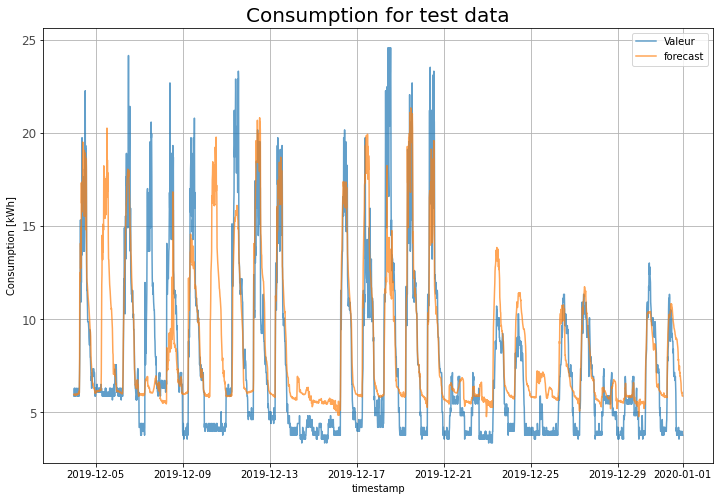

In [195]:
deep_learner.plot_test()

In [164]:
# take the data
filename = 'Consumption_15min.csv'
data27 = pd.read_csv(filename, index_col=0)
# slice some part for an input for the multiple step ahead forecast to continue on
data27 = data27[-672:]
data27

,Valeur
Datetime,
2019-12-25 00:00:00,3.78
2019-12-25 00:15:00,3.99
2019-12-25 00:30:00,3.78
2019-12-25 00:45:00,3.99
2019-12-25 01:00:00,4.20
...,...
2019-12-31 22:45:00,3.78
2019-12-31 23:00:00,3.99
2019-12-31 23:15:00,3.78


Loaded model from disk


,0
2020-01-04 06:00:00,4.846350
2020-01-04 06:15:00,4.851257
2020-01-04 06:30:00,4.853628
2020-01-04 06:45:00,4.848693
2020-01-04 07:00:00,4.781270
...,...
2020-01-07 04:45:00,5.239805
2020-01-07 05:00:00,5.235705
2020-01-07 05:15:00,5.226084
2020-01-07 05:30:00,5.228979


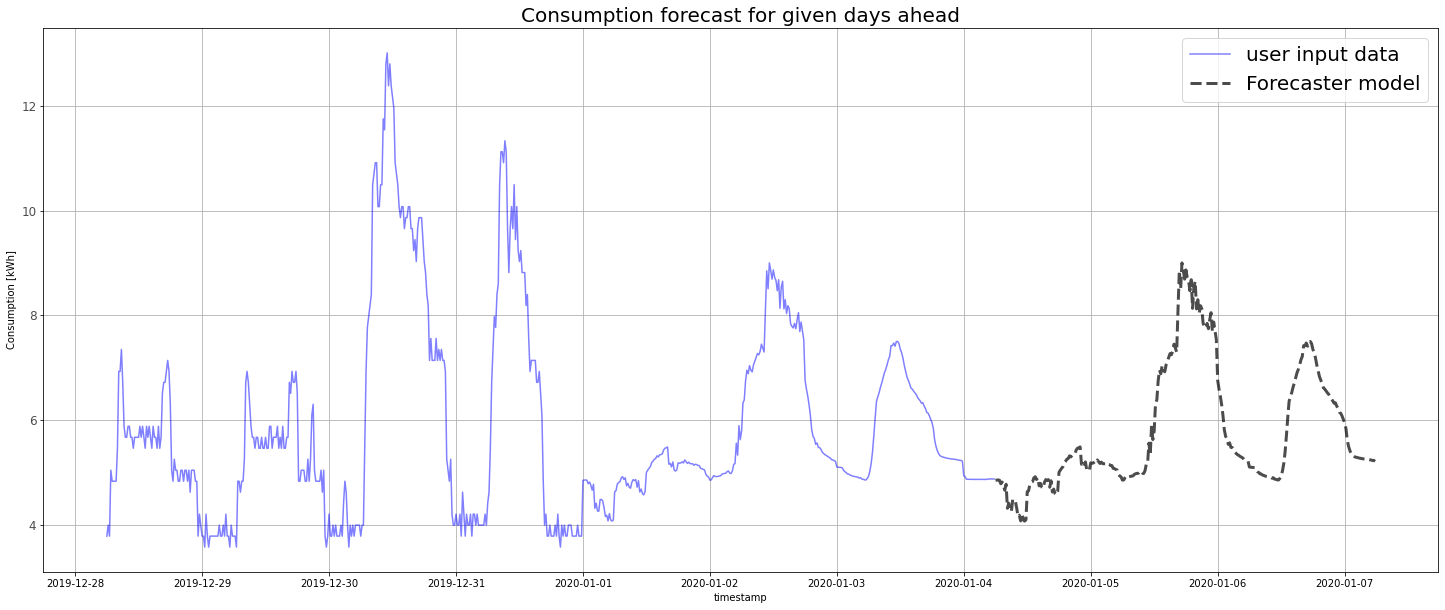

In [171]:
deep_learner.evaluate_n_ahead(data27, 288)        

In [188]:
for i in range(1,28):
    filename = '/Residential_'+str(i)+'.csv'
    print('Loading data '+filename)
    print('\n')
    deep_learner.data_path = '../data/Columbia_clean'+filename
    deep_learner.data = pd.read_csv(deep_learner.data_path, index_col=0)
    deep_learner.data = deep_learner.preprocess(deep_learner.data)
    deep_learner.model_save = 'model_Columbia_B'+str(i)
    # Fitting the model
    model = deep_learner.LSTModel()
    
    original_stdout = sys.stdout # Save a reference to the original standard output
    with open('results_Columbia_logdata.txt', 'a') as f:
        sys.stdout = f # Change the standard output to the file we created.
        print('Building B'+str(i)+':')
        deep_learner.results()        
        sys.stdout = original_stdout # Reset the standard output to its origin

Loading data /Residential_1.csv


Epoch 1/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0909
Epoch 2/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0671
Epoch 3/100
225/225 [==============================] - 1s 4ms/step - loss: 0.0658
Epoch 4/100
225/225 [==============================] - 1s 4ms/step - loss: 0.0650
Epoch 5/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0648
Epoch 6/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0643
Epoch 7/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0638
Epoch 8/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0635
Epoch 9/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0632
Epoch 10/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0627
Epoch 11/100
225/225 [==============================] - 1s 5ms/step - loss: 0.0618
Epoch 12/100
225/225 [==============================] - 1s 5ms

233/233 [==============================] - 1s 5ms/step - loss: 0.0508
Epoch 98/100
233/233 [==============================] - 1s 5ms/step - loss: 0.0508
Epoch 99/100
233/233 [==============================] - 1s 5ms/step - loss: 0.0508
Epoch 100/100
233/233 [==============================] - 1s 5ms/step - loss: 0.0507
Model saved to disk
Loading data /Residential_3.csv


Epoch 1/100
203/203 [==============================] - 1s 5ms/step - loss: 0.1250
Epoch 2/100
203/203 [==============================] - 1s 5ms/step - loss: 0.0919
Epoch 3/100
203/203 [==============================] - 1s 5ms/step - loss: 0.0889
Epoch 4/100
203/203 [==============================] - 1s 5ms/step - loss: 0.0881
Epoch 5/100
203/203 [==============================] - 1s 4ms/step - loss: 0.0873
Epoch 6/100
203/203 [==============================] - 1s 5ms/step - loss: 0.0860
Epoch 7/100
203/203 [==============================] - 1s 5ms/step - loss: 0.0849
Epoch 8/100
203/203 [==============================]

202/202 [==============================] - 1s 5ms/step - loss: 0.0841
Epoch 94/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0840
Epoch 95/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0839
Epoch 96/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0839
Epoch 97/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0840
Epoch 98/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0840
Epoch 99/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0836
Epoch 100/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0838
Model saved to disk
Loading data /Residential_5.csv


Epoch 1/100
202/202 [==============================] - 1s 5ms/step - loss: 0.1149
Epoch 2/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0975
Epoch 3/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0975
Epoch 4/100
202/202 [===========================

202/202 [==============================] - 1s 4ms/step - loss: 0.0577
Epoch 90/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0577
Epoch 91/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0577
Epoch 92/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0576
Epoch 93/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0577
Epoch 94/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0577
Epoch 95/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0577
Epoch 96/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0575
Epoch 97/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0575
Epoch 98/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0576
Epoch 99/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0575
Epoch 100/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0575
Model saved to d

202/202 [==============================] - 1s 4ms/step - loss: 0.0767
Epoch 86/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0766
Epoch 87/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0764
Epoch 88/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0765
Epoch 89/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0764
Epoch 90/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0765
Epoch 91/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0766
Epoch 92/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0764
Epoch 93/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0763
Epoch 94/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0762
Epoch 95/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0764
Epoch 96/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0761
Epoch 97/100
202/

202/202 [==============================] - 1s 5ms/step - loss: 0.0686
Epoch 82/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0687
Epoch 83/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0687
Epoch 84/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0686
Epoch 85/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0688
Epoch 86/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0684
Epoch 87/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0685
Epoch 88/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0684
Epoch 89/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0685
Epoch 90/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0684
Epoch 91/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0683
Epoch 92/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0683
Epoch 93/100
202/

202/202 [==============================] - 1s 5ms/step - loss: 0.0542
Epoch 78/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0543
Epoch 79/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0541
Epoch 80/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0539
Epoch 81/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0538
Epoch 82/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0540
Epoch 83/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0540
Epoch 84/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0541
Epoch 85/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0540
Epoch 86/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0540
Epoch 87/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0539
Epoch 88/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0538
Epoch 89/100
202/

202/202 [==============================] - 1s 5ms/step - loss: 0.0705
Epoch 74/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0704
Epoch 75/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0705
Epoch 76/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0704
Epoch 77/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0704
Epoch 78/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0705
Epoch 79/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0704
Epoch 80/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0703
Epoch 81/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0703
Epoch 82/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0704
Epoch 83/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0702
Epoch 84/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0701
Epoch 85/100
202/

Epoch 71/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1018
Epoch 72/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1017
Epoch 73/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1018
Epoch 74/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1019
Epoch 75/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1019
Epoch 76/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1016
Epoch 77/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1015
Epoch 78/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1018
Epoch 79/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1016
Epoch 80/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1013
Epoch 81/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1013
Epoch 82/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1013
Epoch 83/100
86/86 [========

202/202 [==============================] - 1s 5ms/step - loss: 0.0915
Epoch 71/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0913
Epoch 72/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0914
Epoch 73/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0914
Epoch 74/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0915
Epoch 75/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0912
Epoch 76/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0913
Epoch 77/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0912
Epoch 78/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0913
Epoch 79/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0914
Epoch 80/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0912
Epoch 81/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0911
Epoch 82/100
202/

179/179 [==============================] - 1s 5ms/step - loss: 0.0730
Epoch 67/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0729
Epoch 68/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0728
Epoch 69/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0730
Epoch 70/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0727
Epoch 71/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0727
Epoch 72/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0726
Epoch 73/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0727
Epoch 74/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0726
Epoch 75/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0727
Epoch 76/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0725
Epoch 77/100
179/179 [==============================] - 1s 5ms/step - loss: 0.0723
Epoch 78/100
179/

129/129 [==============================] - 1s 5ms/step - loss: 0.0697
Epoch 65/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0698
Epoch 66/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0698
Epoch 67/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0697
Epoch 68/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0696
Epoch 69/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0696
Epoch 70/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0696
Epoch 71/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0697
Epoch 72/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0696
Epoch 73/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0693
Epoch 74/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0696
Epoch 75/100
129/129 [==============================] - 1s 5ms/step - loss: 0.0694
Epoch 76/100
129/

202/202 [==============================] - 1s 5ms/step - loss: 0.0636
Epoch 61/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0636
Epoch 62/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0635
Epoch 63/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0636
Epoch 64/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0633
Epoch 65/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0634
Epoch 66/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0634
Epoch 67/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0633
Epoch 68/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0632
Epoch 69/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0633
Epoch 70/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0633
Epoch 71/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0632
Epoch 72/100
202/

29/29 [==============================] - 0s 4ms/step - loss: 0.0523
Epoch 58/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0522
Epoch 59/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 60/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0520
Epoch 61/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 62/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 63/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0516
Epoch 64/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 65/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 66/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0515
Epoch 67/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 68/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0512
Epoch 69/100
29/29 [=====================